In [1]:
%load_ext nvcc4jupyter

from nvcc4jupyter import set_defaults
set_defaults(compiler_args='-arch=sm_120 -Xptxas=-v -o out.txt')

Source files will be saved in "/tmp/tmptks3h2_7".


In [2]:
%%cuda
#include<stdio.h>
#include<stdlib.h>
#include<cuda_runtime.h>
#include <cuda/barrier>
#include <cuda/ptx>
using barrier = cuda::barrier<cuda::thread_scope_block>;
namespace ptx = cuda::ptx;

static constexpr size_t buf_len = 1024;
static constexpr int N_blocks = 4;
static constexpr size_t data_len = N_blocks * buf_len;
static constexpr int N_threads_per_block = 64;
__global__ void add_one_kernel(int* data, size_t offset)
{
  //# Shared memory buffer. The destination shared memory buffer of
  //# a bulk operations should be 16 byte aligned.
  __shared__ alignas(16) int smem_data[buf_len];

  //# 1. a) Initialize shared memory barrier with the number of threads participating in the barrier.
  //#3    b) Make initialized barrier visible in async proxy.
  #pragma nv_diag_suppress static_var_with_dynamic_init
  __shared__ barrier bar;
  if (threadIdx.x == 0) { 
    init(&bar, blockDim.x);                      // a)
    ptx::fence_proxy_async(ptx::space_shared);   // b)
  }
  __syncthreads();

  //# 2. Initiate TMA transfer to copy global to shared memory.
  if (threadIdx.x == 0) {
    //# 3a. cuda::memcpy_async arrives on the barrier and communicates
    //#     how many bytes are expected to come in (the transaction count)
    cuda::memcpy_async(
        smem_data, 
        data + offset, 
        cuda::aligned_size_t<16>(sizeof(smem_data)),
        bar
    );
  }
  //# 3b. All threads arrive on the barrier
  barrier::arrival_token token = bar.arrive();
  
  //# 3c. Wait for the data to have arrived.
  bar.wait(std::move(token));

  //# 4. Compute saxpy and write back to shared memory
  for (int i = threadIdx.x; i < buf_len; i += blockDim.x) {
    smem_data[i] += 1;
  }

  //# 5. Wait for shared memory writes to be visible to TMA engine.
  ptx::fence_proxy_async(ptx::space_shared);   // b)
  __syncthreads();
  //# After syncthreads, writes by all threads are visible to TMA engine.

  // #6. Initiate TMA transfer to copy shared memory to global memory
  if (threadIdx.x == 0) {
    ptx::cp_async_bulk(
        ptx::space_global,
        ptx::space_shared,
        data + offset, smem_data, sizeof(smem_data));
    // 7. Wait for TMA transfer to have finished reading shared memory.
    // Create a "bulk async-group" out of the previous bulk copy operation.
    ptx::cp_async_bulk_commit_group();
    // Wait for the group to have completed reading from shared memory.
    ptx::cp_async_bulk_wait_group_read(ptx::n32_t<0>());
  }
}

int main()
{
  int*data_h; 
  cudaHostAlloc(&data_h, data_len, cudaHostAllocDefault); 
  int*data_d; 
  size_t offset = 0;
  cudaMalloc(&data_d, data_len); 
  cudaMemcpy(data_d, data_h, data_len, cudaMemcpyHostToDevice); 
  add_one_kernel<<<N_blocks, N_threads_per_block>>>(data_d, offset);
  cudaDeviceSynchronize(); 
  cudaMemcpy(data_h, data_d, data_len, cudaMemcpyDeviceToHost); 
  for (int i = 0; i < 100; i ++)
  {
    printf("D[%d]: %d ", i, data_h[i]);
  }
  cudaFreeHost(data_h); 
  cudaFree(data_d);
}


D[0]: 1 D[1]: 1 D[2]: 1 D[3]: 1 D[4]: 1 D[5]: 1 D[6]: 1 D[7]: 1 D[8]: 1 D[9]: 1 D[10]: 1 D[11]: 1 D[12]: 1 D[13]: 1 D[14]: 1 D[15]: 1 D[16]: 1 D[17]: 1 D[18]: 1 D[19]: 1 D[20]: 1 D[21]: 1 D[22]: 1 D[23]: 1 D[24]: 1 D[25]: 1 D[26]: 1 D[27]: 1 D[28]: 1 D[29]: 1 D[30]: 1 D[31]: 1 D[32]: 1 D[33]: 1 D[34]: 1 D[35]: 1 D[36]: 1 D[37]: 1 D[38]: 1 D[39]: 1 D[40]: 1 D[41]: 1 D[42]: 1 D[43]: 1 D[44]: 1 D[45]: 1 D[46]: 1 D[47]: 1 D[48]: 1 D[49]: 1 D[50]: 1 D[51]: 1 D[52]: 1 D[53]: 1 D[54]: 1 D[55]: 1 D[56]: 1 D[57]: 1 D[58]: 1 D[59]: 1 D[60]: 1 D[61]: 1 D[62]: 1 D[63]: 1 D[64]: 1 D[65]: 1 D[66]: 1 D[67]: 1 D[68]: 1 D[69]: 1 D[70]: 1 D[71]: 1 D[72]: 1 D[73]: 1 D[74]: 1 D[75]: 1 D[76]: 1 D[77]: 1 D[78]: 1 D[79]: 1 D[80]: 1 D[81]: 1 D[82]: 1 D[83]: 1 D[84]: 1 D[85]: 1 D[86]: 1 D[87]: 1 D[88]: 1 D[89]: 1 D[90]: 1 D[91]: 1 D[92]: 1 D[93]: 1 D[94]: 1 D[95]: 1 D[96]: 1 D[97]: 1 D[98]: 1 D[99]: 1 


In [3]:
%%cuda
#include<stdio.h>
#include<stdlib.h>
#include<cuda_runtime.h>
#include <cuda/barrier>
#include <cuda/ptx>
#include<cuda.h>
using barrier = cuda::barrier<cuda::thread_scope_block>;
namespace ptx = cuda::ptx;
namespace cde = cuda::device::experimental;
#ifndef CUDA_UTILS_H
#define CUDA_UTILS_H



/**
 * @brief Macro to wrap CUDA API calls.
 * * Usage: CUDA_CHECK(cudaMalloc(&d_a, size));
 */
#define CUDA_CHECK(call) \
    { \
        gpuAssert((call), __FILE__, __LINE__); \
    }

/**
 * @brief Internal function to handle the error logic.
 * * @param code The error code returned by the CUDA function.
 * @param file The file name where the error occurred (provided by __FILE__).
 * @param line The line number where the error occurred (provided by __LINE__).
 * @param abort Whether to terminate the application on error (default: true).
 */
inline void gpuAssert(cudaError_t code, const char *file, int line, bool abort = true)
{
    if (code != cudaSuccess) 
    {
        // Print the error name (e.g., cudaErrorMemoryAllocation)
        // and the description (e.g., "out of memory")
        fprintf(stderr, "CUDA_CHECK Error: %s %s\n", 
                cudaGetErrorName(code), 
                cudaGetErrorString(code));
        
        fprintf(stderr, "  File: %s\n", file);
        fprintf(stderr, "  Line: %d\n", line);

        if (abort) 
        {
            // Optional: Reset device to flush profiling data before exit
            cudaDeviceReset();
            exit(code);
        }
    }
}

/**
 * @brief Macro to check for errors after a kernel launch.
 * * Kernel launches are asynchronous. This macro checks:
 * 1. If the launch itself failed (invalid configuration).
 * 2. Synchronizes the device to check for execution errors (bus errors, segfaults).
 * * WARNING: Using this slows down code significantly because of the synchronization.
 * Use only for debugging.
 */
#define CUDA_CHECK_KERNEL() \
    { \
        cudaError_t err = cudaGetLastError(); \
        if (err != cudaSuccess) { \
            fprintf(stderr, "Kernel Launch Error (Sync): %s\n", cudaGetErrorString(err)); \
            gpuAssert(err, __FILE__, __LINE__); \
        } \
        err = cudaDeviceSynchronize(); \
        if (err != cudaSuccess) { \
            fprintf(stderr, "Kernel Execution Error (Async): %s\n", cudaGetErrorString(err)); \
            gpuAssert(err, __FILE__, __LINE__); \
        } \
    }

#endif // CUDA_UTILS_H

#include <cudaTypedefs.h> // PFN_cuTensorMapEncodeTiled, CUtensorMap

PFN_cuTensorMapEncodeTiled_v12000 get_cuTensorMapEncodeTiled() {
  // Get pointer to cuTensorMapEncodeTiled
  cudaDriverEntryPointQueryResult driver_status;
  void* cuTensorMapEncodeTiled_ptr = nullptr;
  CUDA_CHECK(cudaGetDriverEntryPointByVersion("cuTensorMapEncodeTiled", &cuTensorMapEncodeTiled_ptr, 12000, cudaEnableDefault, &driver_status));
  assert(driver_status == cudaDriverEntryPointSuccess);

  return reinterpret_cast<PFN_cuTensorMapEncodeTiled_v12000>(cuTensorMapEncodeTiled_ptr);
}
constexpr uint32_t N = 32; 
constexpr uint32_t BN = 32;
constexpr uint32_t rank = 2; 
constexpr uint32_t GMEM_WIDTH = N; 
constexpr uint32_t GMEM_HEIGHT = N; 
constexpr uint32_t SMEM_WIDTH = BN; 
constexpr uint32_t SMEM_HEIGHT = BN;
uint64_t size[rank] = {GMEM_WIDTH, GMEM_HEIGHT}; //#the faster dimension is always left first. unit is number of elements
uint64_t stride[rank-1] =  {GMEM_WIDTH*sizeof(float)}; //#the number of bytes to step from one row to the next, we are making a row major one here
uint32_t box_size[rank] = {SMEM_WIDTH, SMEM_HEIGHT}; //# I wonder if the reduced stride is taken automatically, but 
//# our boys at NVDA say that things are assumed LINEAR in shared memory so I guess they don't give a fuck, but at this point 
//# the layout is already decided.
uint32_t elem_stride[rank] = {1,1}; //# THIS VIDEO IS ALREADY TOO LONG FOR INSTAGRAM REEEEEELLLL FFS 
//# indeed, the element_strides are something along the lines of if each element is a row major 2 vector then {1,2} would be the elem stride
//# but we have scalar elements so we guuci.

__global__ void tma_kernel(float*A, const __grid_constant__ CUtensorMap tensor_map)
{
    __shared__ alignas(128) float smem_buffer[SMEM_HEIGHT][SMEM_WIDTH];
      #pragma nv_diag_suppress static_var_with_dynamic_init
    __shared__ barrier bar;

    if (threadIdx.x == 0) {
        // #Initialize barrier. All `blockDim.x` threads in block participate.
        init(&bar, blockDim.x);
        // #Make initialized barrier visible in async proxy.
        cde::fence_proxy_async_shared_cta();
    }
    // #Syncthreads so initialized barrier is visible to all threads.
    __syncthreads();
    barrier::arrival_token token;
    if (threadIdx.x == 0) {
        // #Initiate bulk tensor copy.
        cde::cp_async_bulk_tensor_2d_global_to_shared(&smem_buffer, &tensor_map, 0, 0, bar);
        // #Arrive on the barrier and tell how many bytes are expected to come in.
        token = cuda::device::barrier_arrive_tx(bar, 1, sizeof(smem_buffer));
    } else {
        //# Other threads just arrive.
        token = bar.arrive();
    }
    // #Wait for the data to have arrived.
    bar.wait(std::move(token));
      smem_buffer[0][threadIdx.x] += (float) 32.0;

  // #Wait for shared memory writes to be visible to TMA engine.
  cde::fence_proxy_async_shared_cta();
  __syncthreads();
  // #After syncthreads, writes by all threads are visible to TMA engine.

  // #Initiate TMA transfer to copy shared memory to global memory
  if (threadIdx.x == 0) {
    cde::cp_async_bulk_tensor_2d_shared_to_global(&tensor_map, 0, 0, &smem_buffer);
    //# Wait for TMA transfer to have finished reading shared memory.
    // #Create a "bulk async-group" out of the previous bulk copy operation.
    cde::cp_async_bulk_commit_group();
    // #Wait for the group to have completed reading from shared memory.
    cde::cp_async_bulk_wait_group_read<0>();
  }

  //# Destroy barrier. This invalidates the memory region of the barrier. If
  //# further computations were to take place in the kernel, this allows the
  //# memory location of the shared memory barrier to be reused.
  if (threadIdx.x == 0) {
    (&bar)->~barrier();
  }
}

int main()
{
    float* A_h, *A_d; 
    size_t size_tensor = N*N*sizeof(float);
    cudaHostAlloc(&A_h, size_tensor, cudaHostAllocDefault); 
    cudaMalloc(&A_d, size_tensor); 
    void *tensor_ptr =  &A_d; 
    cudaMemcpy(A_d, A_h, size_tensor, cudaMemcpyHostToDevice);
    
    CUtensorMap tensor_map{};
    auto cuTensorMapEncodeTiled = get_cuTensorMapEncodeTiled(); //#function pointer to the tensor map creation api
    CUresult res = cuTensorMapEncodeTiled(
    &tensor_map,                //# CUtensorMap *tensorMap,
    CUtensorMapDataType::CU_TENSOR_MAP_DATA_TYPE_INT32,
    rank,                       //# cuuint32_t tensorRank,
    tensor_ptr,                 //# void *globalAddress,
    size,                       //# const cuuint64_t *globalDim,
    stride,                     //# const cuuint64_t *globalStrides,
    box_size,                   //# const cuuint32_t *boxDim,
    elem_stride,                //# const cuuint32_t *elementStrides,
    //# Interleave patterns can be used to accelerate loading of values that
    //# are less than 4 bytes long.
    CUtensorMapInterleave::CU_TENSOR_MAP_INTERLEAVE_NONE,
    //# Swizzling can be used to avoid shared memory bank conflicts.
    CUtensorMapSwizzle::CU_TENSOR_MAP_SWIZZLE_NONE,
    //# L2 Promotion can be used to widen the effect of a cache-policy to a wider
    //# set of L2 cache lines.
    CUtensorMapL2promotion::CU_TENSOR_MAP_L2_PROMOTION_NONE,
    //# Any element that is outside of bounds will be set to zero by the TMA transfer.
    CUtensorMapFloatOOBfill::CU_TENSOR_MAP_FLOAT_OOB_FILL_NONE
    
    
);
    tma_kernel<<<1,32>>>(A_d, tensor_map);
    cudaDeviceSynchronize();
    cudaMemcpy(A_h, A_d, size_tensor, cudaMemcpyDeviceToHost);
    for (int i = 0; i < 32; i++)
    {
        printf("A[%d]: %f , ", i, A_h[i]);
    }
    cudaFreeHost(A_h); 
    cudaFree(A_d);
    return 0;
}

A[0]: 0.000000 , A[1]: 0.000000 , A[2]: 0.000000 , A[3]: 0.000000 , A[4]: 0.000000 , A[5]: 0.000000 , A[6]: 0.000000 , A[7]: 0.000000 , A[8]: 0.000000 , A[9]: 0.000000 , A[10]: 0.000000 , A[11]: 0.000000 , A[12]: 0.000000 , A[13]: 0.000000 , A[14]: 0.000000 , A[15]: 0.000000 , A[16]: 0.000000 , A[17]: 0.000000 , A[18]: 0.000000 , A[19]: 0.000000 , A[20]: 0.000000 , A[21]: 0.000000 , A[22]: 0.000000 , A[23]: 0.000000 , A[24]: 0.000000 , A[25]: 0.000000 , A[26]: 0.000000 , A[27]: 0.000000 , A[28]: 0.000000 , A[29]: 0.000000 , A[30]: 0.000000 , A[31]: 0.000000 , 


In [4]:
%%cuda
#include <stdio.h>
#include <stdlib.h>
#include <assert.h>
#include <cuda_runtime.h>
#include <cuda.h>
#include <cudaTypedefs.h> 

// Modern C++ CUDA headers for TMA
#include <cuda/barrier>
#include <cuda/ptx>

// Namespaces for cleaner code
using barrier = cuda::barrier<cuda::thread_scope_block>;
namespace cde = cuda::device::experimental;

// --- Helper Macros ---
#define CUDA_CHECK(call) \
    { \
        cudaError_t err = (call); \
        if (err != cudaSuccess) { \
            fprintf(stderr, "CUDA Error: %s at %s:%d\n", \
                    cudaGetErrorString(err), __FILE__, __LINE__); \
            exit(err); \
        } \
    }

// --- Driver API Helper ---
PFN_cuTensorMapEncodeTiled_v12000 get_cuTensorMapEncodeTiled() {
    cudaDriverEntryPointQueryResult driver_status;
    void* ptr = nullptr;
    CUDA_CHECK(cudaGetDriverEntryPointByVersion("cuTensorMapEncodeTiled", &ptr, 12000, cudaEnableDefault, &driver_status));
    return reinterpret_cast<PFN_cuTensorMapEncodeTiled_v12000>(ptr);
}

// --- Constants ---
constexpr uint32_t N = 32; 
constexpr uint32_t BN = 32;
constexpr uint32_t rank = 2; 

// --- Kernel ---
__global__ void tma_kernel(float* A, const __grid_constant__ CUtensorMap tensor_map)
{
    // 1. Shared Memory Buffer (Aligned for TMA)
    __shared__ alignas(128) float smem_buffer[BN][BN];
    
    // 2. MBarrier for synchronization
    #pragma nv_diag_suppress static_var_with_dynamic_init
    __shared__ barrier bar;

    if (threadIdx.x == 0) {
        init(&bar, blockDim.x);
        cde::fence_proxy_async_shared_cta();
    }
    __syncthreads();

    // 3. TMA Load (Global -> Shared)
    barrier::arrival_token token;
    if (threadIdx.x == 0) {
        cde::cp_async_bulk_tensor_2d_global_to_shared(&smem_buffer, &tensor_map, 0, 0, bar);
        token = cuda::device::barrier_arrive_tx(bar, 1, sizeof(smem_buffer));
    } else {
        token = bar.arrive();
    }
    bar.wait(std::move(token));

    // 4. Modify Data
    // Each thread modifies one element in the first row for demonstration
    if (threadIdx.x < BN) {
        smem_buffer[0][threadIdx.x] += 32.0f;
    }

    // 5. Fence to ensure writes are visible to TMA engine
    cde::fence_proxy_async_shared_cta();
    __syncthreads();

    // 6. TMA Store (Shared -> Global)
    if (threadIdx.x == 0) {
        cde::cp_async_bulk_tensor_2d_shared_to_global(&tensor_map, 0, 0, &smem_buffer);
        cde::cp_async_bulk_commit_group();
        cde::cp_async_bulk_wait_group_read<0>();
        // Note: We do not need wait_group_read here, as that is for loads.
        // The store is committed and will complete asynchronously.
    }

    // 7. Cleanup Barrier
    if (threadIdx.x == 0) {
        (&bar)->~barrier();
    }
}

int main()
{
    float *A_h, *A_d; 
    size_t size_tensor = N * N * sizeof(float);
    
    // Allocation
    CUDA_CHECK(cudaHostAlloc(&A_h, size_tensor, cudaHostAllocDefault)); 
    CUDA_CHECK(cudaMalloc(&A_d, size_tensor)); 

    // Initialize Host Data
    for(int i=0; i<N*N; i++) A_h[i] = (float)i;
    CUDA_CHECK(cudaMemcpy(A_d, A_h, size_tensor, cudaMemcpyHostToDevice));
    
    // Tensor Map Configuration
    uint64_t size[rank] = {N, N}; // Elements
    uint64_t stride[rank-1] = {N * sizeof(float)}; // Bytes
    uint32_t box_size[rank] = {BN, BN}; 
    uint32_t elem_stride[rank] = {1, 1};

    // --- FIX: Pass the device pointer directly, cast to void* ---
    void *tensor_ptr = (void*)A_d; 

    CUtensorMap tensor_map{};
    auto cuTensorMapEncodeTiled = get_cuTensorMapEncodeTiled();

    CUresult res = cuTensorMapEncodeTiled(
        &tensor_map,
        // Improved: Use FLOAT32 to match your data
        CUtensorMapDataType::CU_TENSOR_MAP_DATA_TYPE_FLOAT32, 
        rank,
        tensor_ptr, // <--- The Fix
        size,
        stride,
        box_size,
        elem_stride,
        CUtensorMapInterleave::CU_TENSOR_MAP_INTERLEAVE_NONE,
        CUtensorMapSwizzle::CU_TENSOR_MAP_SWIZZLE_NONE,
        CUtensorMapL2promotion::CU_TENSOR_MAP_L2_PROMOTION_NONE,
        CUtensorMapFloatOOBfill::CU_TENSOR_MAP_FLOAT_OOB_FILL_NONE
    );

    if (res != CUDA_SUCCESS) {
        printf("Tensor Map Encode Failed!\n");
        return -1;
    }

    // Launch
    tma_kernel<<<1, 32>>>(A_d, tensor_map);
    CUDA_CHECK(cudaGetLastError());
    
    CUDA_CHECK(cudaDeviceSynchronize());

    // Verify
    CUDA_CHECK(cudaMemcpy(A_h, A_d, size_tensor, cudaMemcpyDeviceToHost));
    
    printf("First 32 elements (Row 0):\n");
    for (int i = 0; i < 32; i++) {
        // Expected: Original Value (i) + 32.0
        printf("%.1f ", A_h[i]);
        
    }
    printf("\n");

    cudaFreeHost(A_h); 
    cudaFree(A_d);
    return 0;
}

First 32 elements (Row 0):
32.0 33.0 34.0 35.0 36.0 37.0 38.0 39.0 40.0 41.0 42.0 43.0 44.0 45.0 46.0 47.0 48.0 49.0 50.0 51.0 52.0 53.0 54.0 55.0 56.0 57.0 58.0 59.0 60.0 61.0 62.0 63.0 



In [5]:
%%cuda
#include <stdio.h>
#include <stdlib.h>
#include <assert.h>
#include <cuda_runtime.h>
#include <cuda.h>
#include <cudaTypedefs.h> 

// Modern C++ CUDA headers for TMA
#include <cuda/barrier>
#include <cuda/ptx>

// Namespaces for cleaner code
using barrier = cuda::barrier<cuda::thread_scope_block>;
namespace cde = cuda::device::experimental;

// --- Helper Macros ---
#define CUDA_CHECK(call) \
    { \
        cudaError_t err = (call); \
        if (err != cudaSuccess) { \
            fprintf(stderr, "CUDA Error: %s at %s:%d\n", \
                    cudaGetErrorString(err), __FILE__, __LINE__); \
            exit(err); \
        } \
    }

// --- Driver API Helper ---
PFN_cuTensorMapEncodeTiled_v12000 get_cuTensorMapEncodeTiled() {
    cudaDriverEntryPointQueryResult driver_status;
    void* ptr = nullptr;
    CUDA_CHECK(cudaGetDriverEntryPointByVersion("cuTensorMapEncodeTiled", &ptr, 12000, cudaEnableDefault, &driver_status));
    return reinterpret_cast<PFN_cuTensorMapEncodeTiled_v12000>(ptr);
}

// --- Constants ---
constexpr uint32_t N = 32; 
constexpr uint32_t BN = 32;
constexpr uint32_t rank = 2; 

// --- Kernel ---
__global__ void tma_kernel(float* A, const __grid_constant__ CUtensorMap tensor_map)
{
    // 1. Shared Memory Buffer (Aligned for TMA)
    __shared__ alignas(128) float smem_buffer[BN][BN];
    
    // 2. MBarrier for synchronization
    #pragma nv_diag_suppress static_var_with_dynamic_init
    __shared__ barrier bar;

    if (threadIdx.x == 0) {
        init(&bar, blockDim.x);
        cde::fence_proxy_async_shared_cta();
    }
    __syncthreads();

    // 3. TMA Load (Global -> Shared)
    barrier::arrival_token token;
    if (threadIdx.x == 0) {
        // Loads the data from Global to Shared. 
        // If swizzling is enabled in the map, it happens here during the write to SMEM.
        cde::cp_async_bulk_tensor_2d_global_to_shared(&smem_buffer, &tensor_map, 0, 0, bar);
        token = cuda::device::barrier_arrive_tx(bar, 1, sizeof(smem_buffer));
    } else {
        token = bar.arrive();
    }
    bar.wait(std::move(token));

    // 4. Fence to ensure the TMA writes are visible to the CUDA cores
    cde::fence_proxy_async_shared_cta();
    __syncthreads();

    // 5. Manual Write Back (Shared -> Global)
    // We do NOT use TMA Store here. We use standard threads to read the SMEM 
    // linearly (as per C++ layout) and write to GMEM.
    // If TMA swizzled the data in step 3, smem_buffer[row][col] will contain
    // the data that physically resides at that offset, revealing the pattern.
    
    // Each thread handles one row (BN elements)
    if (threadIdx.x < BN) {
        for (int i = 0; i < BN; ++i) {
            A[threadIdx.x * BN + i] = smem_buffer[threadIdx.x][i];
        }
    }

    // 6. Cleanup Barrier
    if (threadIdx.x == 0) {
        (&bar)->~barrier();
    }
}

int main()
{
    float *A_h, *A_d; 
    size_t size_tensor = N * N * sizeof(float);
    
    // Allocation
    CUDA_CHECK(cudaHostAlloc(&A_h, size_tensor, cudaHostAllocDefault)); 
    CUDA_CHECK(cudaMalloc(&A_d, size_tensor)); 

    // Initialize Host Data
    for(int i=0; i<N*N; i++) A_h[i] = (float)i;
    CUDA_CHECK(cudaMemcpy(A_d, A_h, size_tensor, cudaMemcpyHostToDevice));
    
    // Tensor Map Configuration
    uint64_t size[rank] = {N, N}; // Elements
    uint64_t stride[rank-1] = {N * sizeof(float)}; // Bytes
    uint32_t box_size[rank] = {BN, BN}; 
    uint32_t elem_stride[rank] = {1, 1};

    // --- FIX: Pass the device pointer directly, cast to void* ---
    void *tensor_ptr = (void*)A_d; 

    CUtensorMap tensor_map{};
    auto cuTensorMapEncodeTiled = get_cuTensorMapEncodeTiled();

    CUresult res = cuTensorMapEncodeTiled(
        &tensor_map,
        // Improved: Use FLOAT32 to match your data
        CUtensorMapDataType::CU_TENSOR_MAP_DATA_TYPE_FLOAT32, 
        rank,
        tensor_ptr, // <--- The Fix
        size,
        stride,
        box_size,
        elem_stride,
        CUtensorMapInterleave::CU_TENSOR_MAP_INTERLEAVE_NONE,
        CUtensorMapSwizzle::CU_TENSOR_MAP_SWIZZLE_128B,
        CUtensorMapL2promotion::CU_TENSOR_MAP_L2_PROMOTION_NONE,
        CUtensorMapFloatOOBfill::CU_TENSOR_MAP_FLOAT_OOB_FILL_NONE
    );

    if (res != CUDA_SUCCESS) {
        printf("Tensor Map Encode Failed!\n");
        return -1;
    }

    // Launch
    tma_kernel<<<1, 32>>>(A_d, tensor_map);
    CUDA_CHECK(cudaGetLastError());
    
    CUDA_CHECK(cudaDeviceSynchronize());

    // Verify
    CUDA_CHECK(cudaMemcpy(A_h, A_d, size_tensor, cudaMemcpyDeviceToHost));
    
    printf("ALL elements :\n");
    for (int i = 0; i < BN*BN; i++) {
        if (i % 32 == 0)
            printf("\n");
        // Expected: Original Value (i) if no swizzle
        printf("%d ", (int) A_h[i]);
    }
    printf("\n");

    cudaFreeHost(A_h); 
    cudaFree(A_d);
    return 0;
}

ALL elements :

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 
36 37 38 39 32 33 34 35 44 45 46 47 40 41 42 43 52 53 54 55 48 49 50 51 60 61 62 63 56 57 58 59 
72 73 74 75 76 77 78 79 64 65 66 67 68 69 70 71 88 89 90 91 92 93 94 95 80 81 82 83 84 85 86 87 
108 109 110 111 104 105 106 107 100 101 102 103 96 97 98 99 124 125 126 127 120 121 122 123 116 117 118 119 112 113 114 115 
144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 
180 181 182 183 176 177 178 179 188 189 190 191 184 185 186 187 164 165 166 167 160 161 162 163 172 173 174 175 168 169 170 171 
216 217 218 219 220 221 222 223 208 209 210 211 212 213 214 215 200 201 202 203 204 205 206 207 192 193 194 195 196 197 198 199 
252 253 254 255 248 249 250 251 244 245 246 247 240 241 242 243 236 237 238 239 232 233 234 235 228 229 230 231 224 225 226 227 
256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 27

In [6]:
%%cuda
#include <stdio.h>
#include <stdlib.h>
#include <assert.h>
#include <cuda_runtime.h>
#include <cuda.h>
#include <cudaTypedefs.h> 

// Modern C++ CUDA headers for TMA
#include <cuda/barrier>
#include <cuda/ptx>

// Namespaces for cleaner code
using barrier = cuda::barrier<cuda::thread_scope_block>;
namespace cde = cuda::device::experimental;

// --- Helper Macros ---
#define CUDA_CHECK(call) \
    { \
        cudaError_t err = (call); \
        if (err != cudaSuccess) { \
            fprintf(stderr, "CUDA Error: %s at %s:%d\n", \
                    cudaGetErrorString(err), __FILE__, __LINE__); \
            exit(err); \
        } \
    }

// --- Driver API Helper ---
PFN_cuTensorMapEncodeTiled_v12000 get_cuTensorMapEncodeTiled() {
    cudaDriverEntryPointQueryResult driver_status;
    void* ptr = nullptr;
    CUDA_CHECK(cudaGetDriverEntryPointByVersion("cuTensorMapEncodeTiled", &ptr, 12000, cudaEnableDefault, &driver_status));
    return reinterpret_cast<PFN_cuTensorMapEncodeTiled_v12000>(ptr);
}

// --- Constants ---
constexpr uint32_t N = 8; 
// BN can be changed, but must ensure BN*BN <= 1024 (Max threads per block)
constexpr uint32_t BN = 8; 
constexpr uint32_t rank = 2; 

static_assert(BN * BN <= 1024, "BN too large for single block 1:1 mapping");

// --- Kernel ---
__global__ void tma_kernel(float* A, const __grid_constant__ CUtensorMap tensor_map)
{
    // 1. Shared Memory Buffer (Aligned for TMA)
    __shared__ alignas(128) float smem_buffer[BN][BN];
    
    // 2. MBarrier for synchronization
    #pragma nv_diag_suppress static_var_with_dynamic_init
    __shared__ barrier bar;

    // Initialize barrier with all threads in the block
    if (threadIdx.x == 0) {
        init(&bar, blockDim.x);
        cde::fence_proxy_async_shared_cta();
    }
    __syncthreads();

    // 3. TMA Load (Global -> Shared)
    // Only thread 0 issues the TMA command
    barrier::arrival_token token;
    if (threadIdx.x == 0) {
        // Loads the data from Global to Shared. 
        // Swizzling (128B) happens here during the write to SMEM banks.
        cde::cp_async_bulk_tensor_2d_global_to_shared(&smem_buffer, &tensor_map, 0, 0, bar);
        token = cuda::device::barrier_arrive_tx(bar, 1, sizeof(smem_buffer));
    } else {
        token = bar.arrive();
    }
    bar.wait(std::move(token));

    // 4. Fence to ensure the TMA writes are visible to the CUDA cores
    cde::fence_proxy_async_shared_cta();
    __syncthreads();

    // 5. Manual Write Back (Shared -> Global) - 1:1 Mapping
    // We treat the SMEM as a flat linear buffer via standard C++ indices.
    // Because TMA wrote physically swizzled data, but we read logically linear data,
    // the output 'A' will contain the swizzled pattern.
    
    int tid = threadIdx.x;
    int row = tid / BN;
    int col = tid % BN;

    // Boundary check usually not needed if BN*BN == blockDim.x, but good practice
    if (row < BN && col < BN) {
        A[tid] = smem_buffer[row][col];
    }

    // 6. Cleanup Barrier
    // Wait for all threads to finish reading before destroying barrier
    __syncthreads();
    if (threadIdx.x == 0) {
        (&bar)->~barrier();
    }
}

int main()
{
    float *A_h, *A_d; 
    size_t size_tensor = N * N * sizeof(float);
    
    // Allocation
    CUDA_CHECK(cudaHostAlloc(&A_h, size_tensor, cudaHostAllocDefault)); 
    CUDA_CHECK(cudaMalloc(&A_d, size_tensor)); 

    // Initialize Host Data with sequential indices to easily track movement
    for(int i=0; i<N*N; i++) A_h[i] = (float)i;
    CUDA_CHECK(cudaMemcpy(A_d, A_h, size_tensor, cudaMemcpyHostToDevice));
    
    // Tensor Map Configuration
    uint64_t size[rank] = {N, N}; // Elements
    uint64_t stride[rank-1] = {N * sizeof(float)}; // Bytes
    uint32_t box_size[rank] = {BN, BN}; 
    uint32_t elem_stride[rank] = {1, 1};

    void *tensor_ptr = (void*)A_d; 

    CUtensorMap tensor_map{};
    auto cuTensorMapEncodeTiled = get_cuTensorMapEncodeTiled();

    CUresult res = cuTensorMapEncodeTiled(
        &tensor_map,
        CUtensorMapDataType::CU_TENSOR_MAP_DATA_TYPE_FLOAT32, 
        rank,
        tensor_ptr, 
        size,
        stride,
        box_size,
        elem_stride,
        CUtensorMapInterleave::CU_TENSOR_MAP_INTERLEAVE_NONE,
        // ENABLE SWIZZLE HERE to detect the pattern
        CUtensorMapSwizzle::CU_TENSOR_MAP_SWIZZLE_32B,
        CUtensorMapL2promotion::CU_TENSOR_MAP_L2_PROMOTION_NONE,
        CUtensorMapFloatOOBfill::CU_TENSOR_MAP_FLOAT_OOB_FILL_NONE
    );

    if (res != CUDA_SUCCESS) {
        printf("Tensor Map Encode Failed!\n");
        return -1;
    }

    // Launch with exactly enough threads for the tile
    // 32*32 = 1024 threads
    tma_kernel<<<1, BN * BN>>>(A_d, tensor_map);
    CUDA_CHECK(cudaGetLastError());
    
    CUDA_CHECK(cudaDeviceSynchronize());

    // Verify
    CUDA_CHECK(cudaMemcpy(A_h, A_d, size_tensor, cudaMemcpyDeviceToHost));
    
    printf("--- Swizzle Pattern Dump (BN=%d) ---\n", BN);
    printf("Value at A[i] implies which original index landed there.\n");
    for (int i = 0; i < BN*BN; i++) {
        if (i % BN == 0)
            printf("\n");
        
        printf("%4d, ", (int)A_h[i]);
    }
    printf("\n");

    cudaFreeHost(A_h); 
    cudaFree(A_d);
    return 0;
}

--- Swizzle Pattern Dump (BN=8) ---
Value at A[i] implies which original index landed there.

   0,    1,    2,    3,    4,    5,    6,    7, 
   8,    9,   10,   11,   12,   13,   14,   15, 
  16,   17,   18,   19,   20,   21,   22,   23, 
  24,   25,   26,   27,   28,   29,   30,   31, 
  36,   37,   38,   39,   32,   33,   34,   35, 
  44,   45,   46,   47,   40,   41,   42,   43, 
  52,   53,   54,   55,   48,   49,   50,   51, 
  60,   61,   62,   63,   56,   57,   58,   59, 



In [7]:
%%cuda

#include <stdio.h>
#include <stdlib.h>
#include <assert.h>
#include <cuda_runtime.h>
#include <cuda.h>
#include <cudaTypedefs.h> 

// Modern C++ CUDA headers for TMA
#include <cuda/barrier>
#include <cuda/ptx>

// Namespaces for cleaner code
using barrier = cuda::barrier<cuda::thread_scope_block>;
namespace cde = cuda::device::experimental;

// --- Helper Macros ---
#define CUDA_CHECK(call) \
    { \
        cudaError_t err = (call); \
        if (err != cudaSuccess) { \
            fprintf(stderr, "CUDA Error: %s at %s:%d\n", \
                    cudaGetErrorString(err), __FILE__, __LINE__); \
            exit(err); \
        } \
    }

// --- Driver API Helper ---
PFN_cuTensorMapEncodeTiled_v12000 get_cuTensorMapEncodeTiled() {
    cudaDriverEntryPointQueryResult driver_status;
    void* ptr = nullptr;
    CUDA_CHECK(cudaGetDriverEntryPointByVersion("cuTensorMapEncodeTiled", &ptr, 12000, cudaEnableDefault, &driver_status));
    return reinterpret_cast<PFN_cuTensorMapEncodeTiled_v12000>(ptr);
}

// --- constants --- 

constexpr int byte_aligner = 128; 
constexpr uint32_t M = 32; 
constexpr uint32_t N = 32; 
constexpr uint32_t BM = 16; 
constexpr uint32_t BN = 8;
constexpr uint32_t GM = M/BM; 
constexpr uint32_t GN = N/BN;
constexpr uint32_t rank = 2; 

static_assert(BM*BN <= 1024, "too many threads");

constexpr uint64_t tensor_shape[rank] = {N,M}; //fast dimension first 
constexpr uint64_t tensor_stride[rank-1] = {N*sizeof(float)}; //number of bytes in the fast dimension is the stride
constexpr uint32_t smem_box_shape[rank] = {BN,BM}; 
constexpr uint32_t element_stride[rank] = {1,1};
constexpr size_t gmem_tensor_size = M*N*sizeof(float);

__global__ void tma_kernel(float* A, const __grid_constant__ CUtensorMap tensor_map)
{
    uint x = blockIdx.x*blockDim.x; 
    uint y = blockIdx.y*blockDim.y;
    __shared__ alignas(byte_aligner) float As[BM][BN];  // declared aligned shared memory 

    #pragma nv_diag_suppress static_var_with_dynamic_init // tells compiler hey chill the fuck out we know whats good.
    __shared__ barrier bar;

    if (threadIdx.x == 0) {
        init(&bar, BM*BN);
        cde::fence_proxy_async_shared_cta(); // special proxy that waits and ensures that the TMA engine has visibility to the bar. 
    }
    __syncthreads(); // ensure all thereads are all synced up before using the barrier (bootstrapped init)

    barrier::arrival_token token;
    if (threadIdx.x == 0)
    {
        // Loads the data from Global to Shared. 
        // Swizzling (128B) happens here during the write to SMEM banks.
        cde::cp_async_bulk_tensor_2d_global_to_shared(&As, &tensor_map, x, y, bar);
        token = cuda::device::barrier_arrive_tx(bar, 1, sizeof(As));
    } 
    else {
        token = bar.arrive();
    }

    bar.wait(std::move(token));
    cde::fence_proxy_async_shared_cta();
    __syncthreads();

    uint smem_col = threadIdx.x; 
    uint smem_row = threadIdx.y; 
    uint gmem_row = y + smem_row;
    uint gmem_col = x + smem_col;
    A[gmem_row*N + gmem_col] = As[smem_row][smem_col];
}

int main()
{
    float* A_h, *A_d; 
    cudaHostAlloc(&A_h, gmem_tensor_size, cudaHostAllocDefault); 
    cudaMalloc(&A_d, gmem_tensor_size); 
    for (int i = 0; i < M*N; i++)
    {
        A_h[i] = (float) i; 
    }
    cudaMemcpy(A_d, A_h, gmem_tensor_size, cudaMemcpyHostToDevice); 
    auto cuTensorMapEncodeTiled = get_cuTensorMapEncodeTiled();
    CUtensorMap tensor_map{};
    void *tensor_ptr = (void*)A_d; 
    CUresult res = cuTensorMapEncodeTiled(
        &tensor_map,
        CUtensorMapDataType::CU_TENSOR_MAP_DATA_TYPE_FLOAT32, 
        rank,
        tensor_ptr, 
        tensor_shape,
        tensor_stride,
        smem_box_shape,
        element_stride,
        CUtensorMapInterleave::CU_TENSOR_MAP_INTERLEAVE_NONE,
        CUtensorMapSwizzle::CU_TENSOR_MAP_SWIZZLE_32B,
        CUtensorMapL2promotion::CU_TENSOR_MAP_L2_PROMOTION_NONE,
        CUtensorMapFloatOOBfill::CU_TENSOR_MAP_FLOAT_OOB_FILL_NONE
    );

    if (res != CUDA_SUCCESS) {
        printf("Tensor Map Encode Failed!\n");
        return -1;
    }

    dim3 grid(GN, GM); 
    dim3 block(BN, BM);
    tma_kernel<<<grid, block>>>(A_d, tensor_map);
    cudaDeviceSynchronize();
    cudaMemcpy(A_h, A_d, gmem_tensor_size, cudaMemcpyDeviceToHost);
    for (int i = 0; i < N*M; i++) printf("%d, ", (int) A_h[i]);

}

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 132, 133, 134, 135, 128, 129, 130, 131, 140, 141, 142, 143, 136, 137, 138, 139, 148, 149, 150, 151, 144, 145, 146, 147, 156, 157, 158, 159, 152, 153, 154, 155, 164, 165, 166, 167, 160, 161, 162, 163, 172, 173, 174, 175, 168, 169, 170, 171, 180, 181, 182, 183, 176, 177, 178, 179, 188, 189, 190, 191, 184, 185, 186, 187, 196, 197, 198, 199, 192, 193, 194, 195, 204, 205, 206, 207, 200, 201, 202, 203, 212, 213, 214, 215, 208, 209, 210, 211, 220, 221, 222, 223, 216, 217, 

In [17]:
%%cuda

#include <stdio.h>
#include <stdlib.h>
#include <assert.h>
#include <cuda_runtime.h>
#include <cuda.h>
#include <cudaTypedefs.h> 
#include <cuda_bf16.h>

// Modern C++ CUDA headers for TMA
#include <cuda/barrier>
#include <cuda/ptx>

// Namespaces for cleaner code
using barrier = cuda::barrier<cuda::thread_scope_block>;
namespace cde = cuda::device::experimental;

// --- Helper Macros ---
#define CUDA_CHECK(call) \
    { \
        cudaError_t err = (call); \
        if (err != cudaSuccess) { \
            fprintf(stderr, "CUDA Error: %s at %s:%d\n", \
                    cudaGetErrorString(err), __FILE__, __LINE__); \
            exit(err); \
        } \
    }

// --- Driver API Helper ---
PFN_cuTensorMapEncodeTiled_v12000 get_cuTensorMapEncodeTiled() {
    cudaDriverEntryPointQueryResult driver_status;
    void* ptr = nullptr;
    CUDA_CHECK(cudaGetDriverEntryPointByVersion("cuTensorMapEncodeTiled", &ptr, 12000, cudaEnableDefault, &driver_status));
    return reinterpret_cast<PFN_cuTensorMapEncodeTiled_v12000>(ptr);
}

// --- constants --- 

constexpr int byte_aligner = 1024; 
constexpr uint32_t M = 32; 
constexpr uint32_t N = 32; 
constexpr uint32_t BM = 32; 
constexpr uint32_t BN = 32;
constexpr uint32_t GM = M/BM; 
constexpr uint32_t GN = N/BN;
constexpr uint32_t rank = 2; 

static_assert(BM*BN/2 <= 1024, "too many threads");

constexpr uint64_t tensor_shape[rank] = {N,M}; //fast dimension first 
constexpr uint64_t tensor_stride[rank-1] = {N*sizeof(__nv_bfloat16)}; //number of bytes in the fast dimension is the stride
constexpr uint32_t smem_box_shape[rank] = {BN,BM}; 
constexpr uint32_t element_stride[rank] = {1,1};
constexpr size_t gmem_tensor_size = M*N*sizeof(__nv_bfloat16);

__global__ void tma_kernel(__nv_bfloat16* A, const __grid_constant__ CUtensorMap tensor_map)
{
    uint x = blockIdx.x*blockDim.x; 
    uint y = blockIdx.y*blockDim.y;
    __shared__ alignas(byte_aligner) __nv_bfloat16 As[BM][BN];  // declared aligned shared memory 

    #pragma nv_diag_suppress static_var_with_dynamic_init // tells compiler hey chill the fuck out we know whats good.
    __shared__ barrier bar;

    if (threadIdx.x == 0) {
        init(&bar, BM*BN);
        cde::fence_proxy_async_shared_cta(); // special proxy that waits and ensures that the TMA engine has visibility to the bar. 
    }
    __syncthreads(); // ensure all thereads are all synced up before using the barrier (bootstrapped init)

    barrier::arrival_token token;
    if (threadIdx.x == 0)
    {
        // Loads the data from Global to Shared. 
        // Swizzling (128B) happens here during the write to SMEM banks.
        cde::cp_async_bulk_tensor_2d_global_to_shared(&As, &tensor_map, x, y, bar);
        token = cuda::device::barrier_arrive_tx(bar, 1, sizeof(As));
    } 
    else {
        token = bar.arrive();
    }

    bar.wait(std::move(token));
    cde::fence_proxy_async_shared_cta();
    __syncthreads();

    uint smem_col = threadIdx.x; 
    uint smem_row = threadIdx.y; 
    uint gmem_row = y + smem_row;
    uint gmem_col = x + smem_col;
    A[gmem_row*N + gmem_col] = As[smem_row][smem_col];
}

int main()
{
    __nv_bfloat16 * A_h, *A_d; 
    cudaHostAlloc(&A_h, gmem_tensor_size, cudaHostAllocDefault); 
    cudaMalloc(&A_d, gmem_tensor_size); 
    for (int i = 0; i < M*N; i++)
    {
        A_h[i] = __float2bfloat16((float) (i% (BN*BM))); 
    }
    cudaMemcpy(A_d, A_h, gmem_tensor_size, cudaMemcpyHostToDevice); 
    auto cuTensorMapEncodeTiled = get_cuTensorMapEncodeTiled();
    CUtensorMap tensor_map{};
    void *tensor_ptr = (void*)A_d; 
    CUresult res = cuTensorMapEncodeTiled(
        &tensor_map,
        CUtensorMapDataType::CU_TENSOR_MAP_DATA_TYPE_BFLOAT16, 
        rank,
        tensor_ptr, 
        tensor_shape,
        tensor_stride,
        smem_box_shape,
        element_stride,
        CUtensorMapInterleave::CU_TENSOR_MAP_INTERLEAVE_NONE,
        CUtensorMapSwizzle::CU_TENSOR_MAP_SWIZZLE_64B,
        CUtensorMapL2promotion::CU_TENSOR_MAP_L2_PROMOTION_NONE,
        CUtensorMapFloatOOBfill::CU_TENSOR_MAP_FLOAT_OOB_FILL_NONE
    );

    if (res != CUDA_SUCCESS) {
        printf("Tensor Map Encode Failed!\n");
        return -1;
    }

    dim3 grid(GN, GM); 
    dim3 block(BN, BM);
    tma_kernel<<<grid, block>>>(A_d, tensor_map);
    cudaDeviceSynchronize();
    cudaMemcpy(A_h, A_d, gmem_tensor_size, cudaMemcpyDeviceToHost);
    for (int i = 0; i < N*M; i++) printf("%d, ", (int) A_h[i]);

}


0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 72, 73, 74, 75, 76, 77, 78, 79, 64, 65, 66, 67, 68, 69, 70, 71, 88, 89, 90, 91, 92, 93, 94, 95, 80, 81, 82, 83, 84, 85, 86, 87, 104, 105, 106, 107, 108, 109, 110, 111, 96, 97, 98, 99, 100, 101, 102, 103, 120, 121, 122, 123, 124, 125, 126, 127, 112, 113, 114, 115, 116, 117, 118, 119, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 216, 217, 218, 219, 220, 221, 222, 223, 208, 209, 210, 211, 212, 213, 214, 215, 200, 201, 202, 203, 204, 205, 206, 207, 192, 193, 194, 195, 196, 197, 

In [12]:
from PyLayouts import Draw
import numpy as np

In [24]:
L = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63])

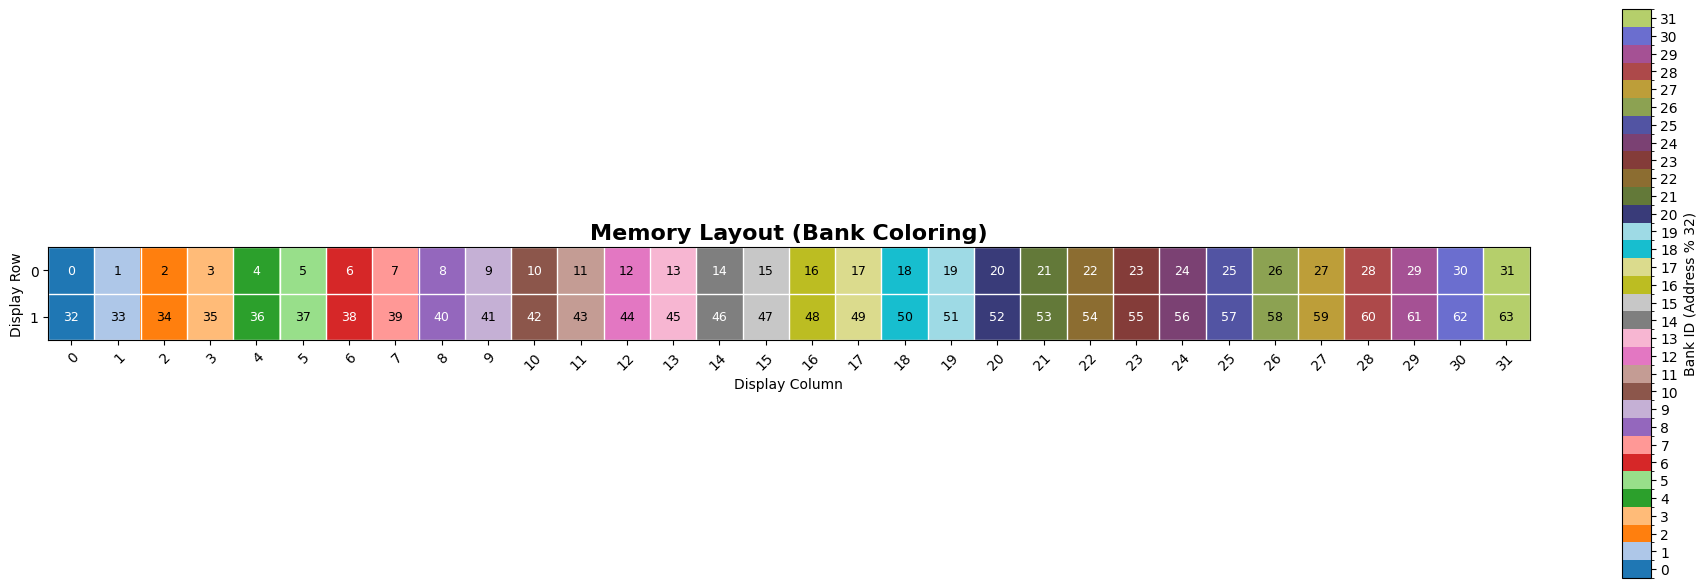

In [25]:
D = Draw(L, 32)
D.show(mode = 'bank')

In [22]:
%%cuda

#include <stdio.h>
#include <stdlib.h>
#include <assert.h>
#include <cuda_runtime.h>
#include <cuda.h>
#include <cudaTypedefs.h> 
#include <cuda_bf16.h>

// Modern C++ CUDA headers for TMA
#include <cuda/barrier>
#include <cuda/ptx>

// Namespaces for cleaner code
using barrier = cuda::barrier<cuda::thread_scope_block>;
namespace cde = cuda::device::experimental;

// --- Helper Macros ---
#define CUDA_CHECK(call) \
    { \
        cudaError_t err = (call); \
        if (err != cudaSuccess) { \
            fprintf(stderr, "CUDA Error: %s at %s:%d\n", \
                    cudaGetErrorString(err), __FILE__, __LINE__); \
            exit(err); \
        } \
    }

// --- Driver API Helper ---
PFN_cuTensorMapEncodeTiled_v12000 get_cuTensorMapEncodeTiled() {
    cudaDriverEntryPointQueryResult driver_status;
    void* ptr = nullptr;
    CUDA_CHECK(cudaGetDriverEntryPointByVersion("cuTensorMapEncodeTiled", &ptr, 12000, cudaEnableDefault, &driver_status));
    return reinterpret_cast<PFN_cuTensorMapEncodeTiled_v12000>(ptr);
}

// --- constants --- 

constexpr int byte_aligner = 1024; 
constexpr uint32_t M = 8; 
constexpr uint32_t N = 8; 
constexpr uint32_t BM = 8; 
constexpr uint32_t BN = 8;
constexpr uint32_t GM = M/BM; 
constexpr uint32_t GN = N/BN;
constexpr uint32_t rank = 2; 

static_assert(BM*BN/2 <= 1024, "too many threads");

constexpr uint64_t tensor_shape[rank] = {N,M}; //fast dimension first 
constexpr uint64_t tensor_stride[rank-1] = {N*sizeof(__nv_bfloat16)}; //number of bytes in the fast dimension is the stride
constexpr uint32_t smem_box_shape[rank] = {BN,BM}; 
constexpr uint32_t element_stride[rank] = {1,1};
constexpr size_t gmem_tensor_size = M*N*sizeof(__nv_bfloat16);

__global__ void tma_kernel(__nv_bfloat16* A, const __grid_constant__ CUtensorMap tensor_map)
{
    uint x = blockIdx.x*blockDim.x; 
    uint y = blockIdx.y*blockDim.y;
    __shared__ alignas(byte_aligner) __nv_bfloat16 As[BM][BN];  // declared aligned shared memory 

    #pragma nv_diag_suppress static_var_with_dynamic_init // tells compiler hey chill the fuck out we know whats good.
    __shared__ barrier bar;

    if (threadIdx.x == 0) {
        init(&bar, BM*BN);
        cde::fence_proxy_async_shared_cta(); // special proxy that waits and ensures that the TMA engine has visibility to the bar. 
    }
    __syncthreads(); // ensure all thereads are all synced up before using the barrier (bootstrapped init)

    barrier::arrival_token token;
    if (threadIdx.x == 0)
    {
        // Loads the data from Global to Shared. 
        // Swizzling (128B) happens here during the write to SMEM banks.
        cde::cp_async_bulk_tensor_2d_global_to_shared(&As, &tensor_map, x, y, bar);
        token = cuda::device::barrier_arrive_tx(bar, 1, sizeof(As));
    } 
    else {
        token = bar.arrive();
    }

    bar.wait(std::move(token));
    cde::fence_proxy_async_shared_cta();
    __syncthreads();

    uint smem_col = threadIdx.x; 
    uint smem_row = threadIdx.y; 
    uint gmem_row = y + smem_row;
    uint gmem_col = x + smem_col;
    A[gmem_row*N + gmem_col] = As[smem_row][smem_col];
}

int main()
{
    __nv_bfloat16 * A_h, *A_d; 
    cudaHostAlloc(&A_h, gmem_tensor_size, cudaHostAllocDefault); 
    cudaMalloc(&A_d, gmem_tensor_size); 
    for (int i = 0; i < M*N; i++)
    {
        A_h[i] = __float2bfloat16((float) (i% (BN*BM))); 
    }
    cudaMemcpy(A_d, A_h, gmem_tensor_size, cudaMemcpyHostToDevice); 
    auto cuTensorMapEncodeTiled = get_cuTensorMapEncodeTiled();
    CUtensorMap tensor_map{};
    void *tensor_ptr = (void*)A_d; 
    CUresult res = cuTensorMapEncodeTiled(
        &tensor_map,
        CUtensorMapDataType::CU_TENSOR_MAP_DATA_TYPE_BFLOAT16, 
        rank,
        tensor_ptr, 
        tensor_shape,
        tensor_stride,
        smem_box_shape,
        element_stride,
        CUtensorMapInterleave::CU_TENSOR_MAP_INTERLEAVE_NONE,
        CUtensorMapSwizzle::CU_TENSOR_MAP_SWIZZLE_128B,
        CUtensorMapL2promotion::CU_TENSOR_MAP_L2_PROMOTION_NONE,
        CUtensorMapFloatOOBfill::CU_TENSOR_MAP_FLOAT_OOB_FILL_NONE
    );

    if (res != CUDA_SUCCESS) {
        printf("Tensor Map Encode Failed!\n");
        return -1;
    }

    dim3 grid(GN, GM); 
    dim3 block(BN, BM);
    tma_kernel<<<grid, block>>>(A_d, tensor_map);
    cudaDeviceSynchronize();
    cudaMemcpy(A_h, A_d, gmem_tensor_size, cudaMemcpyDeviceToHost);
    for (int i = 0; i < N*M; i++) printf("%d, ", (int) A_h[i]);

}


0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 
